In [1]:
import torch
import sys
import os
import os.path as osp
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, \
balanced_accuracy_score, accuracy_score
from sklearn import metrics
import math
from shapely.geometry import Point
from shapely.ops import cascaded_union
from matplotlib.collections import PolyCollection

In [2]:
os.environ['USER_PATH']='/home/users/richras/Ge2Net_Repo'
os.environ['USER_SCRATCH_PATH']="/scratch/users/richras"
os.environ['IN_PATH']='/scratch/groups/cdbustam/richras/data_in'
os.environ['OUT_PATH']='/scratch/groups/cdbustam/richras/data_out'
os.environ['LOG_PATH']='/scratch/groups/cdbustam/richras/logs/'

In [3]:
os.chdir(os.environ.get('USER_PATH'))

In [4]:
%load_ext autoreload
%autoreload 2
from src.utils.dataUtil import load_path, save_file, vcf2npy, get_recomb_rate, interpolate_genetic_pos, form_windows
from src.utils.modelUtil import Params, load_model
from src.utils.labelUtil import nearestNeighbourMapping, repeat_pop_arr
from src.utils.decorators import timer
from src.models import AuxiliaryTask, LSTM, Attention, BasicBlock, Model_A, Model_B, Model_C, BOCD
from src.models.distributions import Multivariate_Gaussian
from src.main.dataset import Haplotype
from src.main.evaluation import eval_cp_batch, reportChangePointMetrics, t_prMetrics, cpMethod, eval_cp_matrix, \
getCpPred
import inference

# load the model and use valid data 

In [5]:
# Specify the dataset to be evaluated
# chm22 pca full dataset and model
labels_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_1_pca')
data_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_1_pca')
models_path=osp.join(os.environ['OUT_PATH'],'humans/training/Model_Q_exp_id_1_data_id_1_pca/') 
dataset_type='test'

In [6]:
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
config['model.loadBest']=True
yaml_path = osp.join(config['models.dir'], 'params.yaml')
assert osp.isfile(yaml_path), "No json configuration file found at {}".format(yaml_path)
params = Params(yaml_path)
params.rtnOuts=True
params.mc_dropout=True
params.mc_samples=100
params.cp_tol=0
params.balancedLoss=False
params.evalCp=True
results, test_dataset,_,_=inference.main(config, params)

INFO: __init__:src.main.dataset: Loading test Dataset
INFO: __init__:src.main.dataset:Loading gen 0
INFO: __init__:src.main.dataset: snps data: (564, 317410)


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: y_labels data :(564, 317410)
INFO: __init__:src.main.dataset:Loading gen 2
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 4
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 8
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished 'mapping_func' in 0.3660 secs
Finished 'pop_mapping' in 0.1309 secs
Finished 'pop_mapping' in 0.1329 secs
Finished 'transform_data' in 32.5225 secs
Finished '__init__' in 42.6471 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:107528
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31891819
device in load model:None
Finished 'load_model' in 0.1983 secs
best val loss metrics : {'loss_main': 0.32982670098526423, 'loss_aux': 0.8378495132421891, 'gcd': None, 'mse': 0.17319945671879727, 'smooth_l1': 0.08350094807714122, 'weighted_loss': 0.32982670098526423}
at epoch : 131
train loss metrics: {'loss_main': 0.31123373579025687, 'loss_aux': 0.7249774828171883, 'gcd': None, 'mse': 0.09206160483954577, 'smooth_l1': 0.045924477757158993, 'weighted_loss': 0.31123373579025687}
best val cp metrics : {'loss_cp': 0.2588518878027973, 'prMetrics': OrderedDict([('Precision', array(0.36076843)), ('Reca

In [7]:
train_dataset = Haplotype("train", params, data_path, labels_path=labels_path)

INFO: __init__:src.main.dataset: Loading train Dataset
INFO: __init__:src.main.dataset:Loading gen 0
INFO: __init__:src.main.dataset: snps data: (4116, 317410)
INFO: __init__:src.main.dataset: y_labels data :(4116, 317410)
INFO: __init__:src.main.dataset:Loading gen 2
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 4
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 8
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished 'mapping_func' in 0.8089 secs
Finished 'pop_mapping' in 0.2944 secs
Finished 'pop_mapping' in 0.2966 secs
Finished 'transform_data' in 71.2956 secs
Finished '__init__' in 95.7891 secs


In [8]:
results.t_accr, results.t_cp_accr

({'gcd': None,
  'loss_aux': 0.8373349999880266,
  'loss_main': 0.3766868721649808,
  'mse': 0.2077478971127172,
  'smooth_l1': 0.1003781191031335,
  'weighted_loss': 0.3766868721649808},
 {'loss_cp': 0.2300283781919243,
  'prMetrics': OrderedDict([('Precision', array(0.29111123)),
               ('Recall', array(0.70585299)),
               ('Accuracy', array(0.9828329)),
               ('A_major', array(0.98521536)),
               ('BalancedAccuracy', 0.8455341749875436)])})

In [9]:
results.t_out.coord_main.shape

(100, 2964, 317, 3)

In [10]:
results.t_out.coord_main=results.t_out.coord_main.mean(0)

In [11]:
y_pred = results.t_out.coord_main
n_vec_dim=y_pred.shape[-1]
data_tensor = torch.tensor(y_pred).float()
batch_size_cpd = data_tensor.shape[0]
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
mean_var=torch.mean(torch.var(data_tensor, dim =1),dim=0).unsqueeze(0)
cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = cov_prior
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
posterior, log_prob_r_joint_x, log_p_xt1_given_xt, e_mean=model_cpd.run_recursive(data_tensor, 'cpu')

Finished 'run_recursive' in 151.9626 secs


In [12]:
granular_pop_dict = load_path(osp.join(labels_path, 'granular_pop.pkl'), en_pickle=True)
superpop_dict=load_path(osp.join(labels_path, 'superpop.pkl'), en_pickle=True)
pop_sample_map=pd.read_csv(osp.join(labels_path, 'pop_sample_map.tsv'),sep="\t")
pop_arr=repeat_pop_arr(pop_sample_map)
cp_target=test_dataset.data['cps']
seqlen=cp_target.shape[1]
rev_pop_dict={v:k for k,v in granular_pop_dict.items()}
rev_sp_dict={v:k for k,v in superpop_dict.items()}

In [62]:
# index=1916 #used in main panel
# index=1400 #possible for cp
# index=1503  #possible for cp
# index=1509 #possible for cp
# index=1512#possible for cp
# index=1513
# index=1515
# # index=1517
# # index=1520
# # index=1521
# index=1535
# index=1540
# index=1541#final
# index=1545
# index=1548
# index=1549
# index=1566
# index=1570
# index=1580
# index=1582
# index=1583#final
index=1584
# index=1592# good for all methods except NN
# index=1597#all good
# index=1610
# index=1503 
# index=np.random.choice(idxOfInterest)
print(index)
true_cpsSample=cp_target[index,:]
y_predSample=results.t_out.coord_main[index,:]
y_trueSample=test_dataset.data['y'][index,:]
granularpopSample=test_dataset.data['granular_pop'][index,:]
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
superPopSample=test_dataset.data['superpop'][index,:]
SpNamesSample=[rev_sp_dict[i] for i in superPopSample.astype(int)]

1584


In [63]:
y_predSample.shape

(317, 3)

In [64]:
predBOCDSample=model_cpd.cp[index,:]
pred_cps_BOCD=getCpPred(cpMethod.BOCD.name, predBOCDSample, 3.0, 1, len(true_cpsSample))
pred_cps_BOCD=pred_cps_BOCD.squeeze(0).detach().cpu().numpy()# squeeze the batch dimension of 1

In [86]:
def plot_changepoints(true_cps, pred_cps, y_pred, bocp_rl, gradient_cp, nn_cp, mc_cp, popNames, mc_var, pred_var):
    fig, ax = plt.subplots(5,1,figsize=[18,20])
    T=len(true_cps)
    ax[0].plot(y_pred, linewidth=3, label='coordinate predictions')
    ax[0].text(0, np.max(y_pred)-0.5, s=popNames[0], size=15)
    for i in np.nonzero(true_cps)[0]:
        ax[0].text(i, np.max(y_pred)-0.5, s=popNames[i+1], size=10, zorder=5)
        for j in range(5):
            ax[j].plot([i,i], [np.min(y_pred), np.max(y_pred)], 'r' , zorder=5, label='true changepoint')
            ax[j].tick_params(which='major', width=2, length=10, labelsize=15)
        
    ax[1].plot(nn_cp, linewidth=3, color='teal', label='predicted changepoint')
    ax[2].plot(gradient_cp.reshape(-1,1), linewidth=3, color='teal')
    ax[2].plot(pred_var, linestyle='--', c='skyblue', label='variance')
    ax[3].plot(mc_cp.reshape(-1,1), linewidth=3, color='teal')
    ax[3].plot(mc_var, linestyle='--', c='skyblue')
    ax[4].plot(pred_cps, linewidth=3, color='teal')

    patches=[]
    patches.append(ax[0].scatter([],[], marker="_", label='True Changepoint', color='r', s=600))
    patches.append(ax[0].scatter([],[], marker="_", label='Predicted Changepoint', color='teal', s=600))
    patches.append(ax[0].scatter([],[], marker="_", label='Variance', color='skyblue', s=600))
    lgnd = ax[0].legend(handles=patches, loc="upper right", fontsize=15, bbox_to_anchor=(-0.35, 0.37, 1., .5))
    ax[0].add_artist(lgnd)
#     ax[0].set_title("Ge3Net Predictions", fontsize=25)
#     ax[1].set_title("Neural Network predicted changepoints", fontsize=25)
#     ax[2].set_title("Gradient predicted changepoints", fontsize=25)
#     ax[3].set_title("MC Dropout predicted changepoints", fontsize=25)
#     ax[4].set_title("BCD predicted changepoints", fontsize=25)
    plt.show()

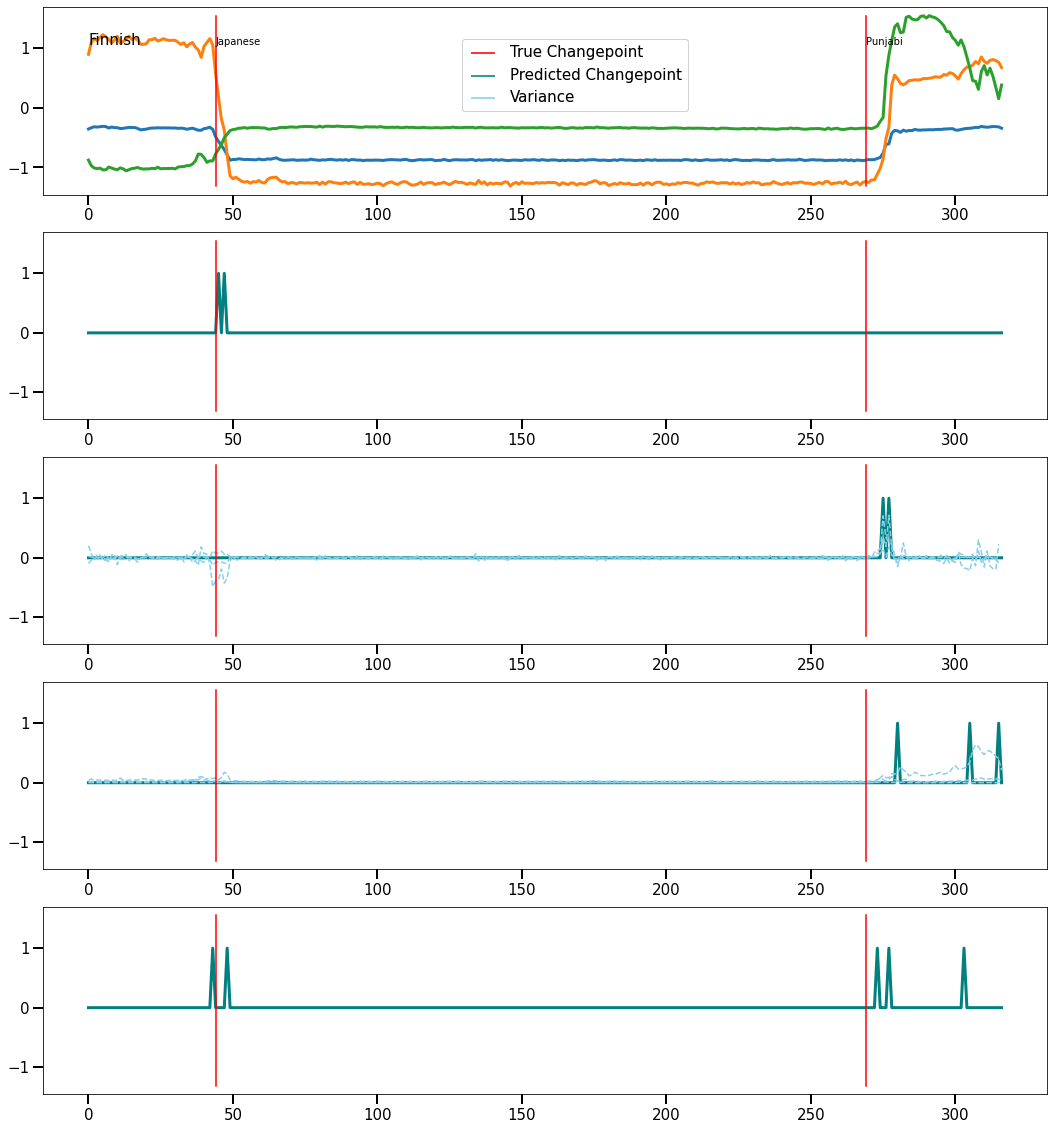

In [87]:
pred_var=y_predSample[1:,:]-y_predSample[:-1,:]
gradeint_cp = getCpPred(cpMethod.gradient.name, torch.tensor(results.t_out.coord_main).float()[index,:], 0.5, \
                1, len(true_cpsSample))
nn_cp=getCpPred(cpMethod.neural_network.name, torch.tensor(results.t_out.cp_logits).float()[index,:], 0.85, \
                1, len(true_cpsSample))
mc_cp=getCpPred(cpMethod.mc_dropout.name, torch.tensor(results.t_out.y_var).float()[index,:], 0.1, 1, \
              len(true_cpsSample))
mc_var=results.t_out.y_var[index,:,:]
bocp_rlSample=model_cpd.cp.detach().cpu().numpy()[index,:]
plot_changepoints(true_cpsSample, pred_cps_BOCD, y_predSample, bocp_rlSample, gradeint_cp, nn_cp, mc_cp, namesSample,\
                 mc_var, pred_var)

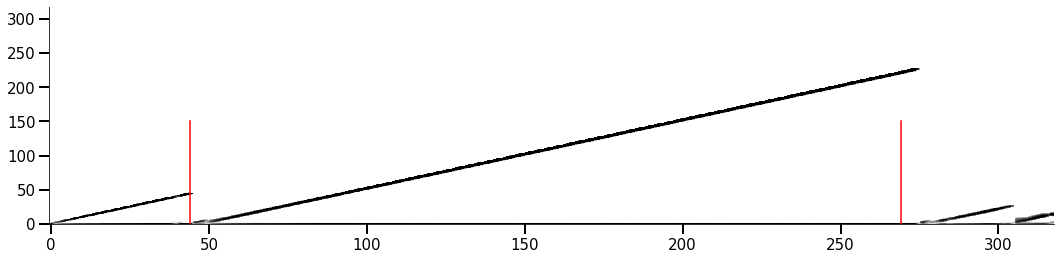

In [67]:
# plot run length
fig, ax = plt.subplots(1,1,figsize=[18,4])
ax.imshow(np.exp(log_prob_r_joint_x[index,:].detach().cpu().numpy()), aspect='auto', cmap='gray_r', 
               norm=LogNorm(vmin=0.0001, vmax=1), origin='lower')
#plot red line at true changepoints
for i in np.nonzero(true_cpsSample)[0]:
    ax.plot([i,i], [0, 150], 'r')
#remove the box lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#make the axis tick bigger
ax.tick_params(which='major', width=2, length=10, labelsize=15)
plt.show()

In [137]:
np.nonzero(true_cpsSample)[0]

array([ 94, 121, 259])